# Notebook to train the Hybrid ResNet-ViT

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
from models3D import ResnetFeatureExtractor, ResNetViT
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

#clean_zone_identifier_files("/home/diogommiranda/tese/")

Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [21]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size
INPUT_ROI_MASK_PATH = None # Set to None to not apply mask to the images

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=INPUT_ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=INPUT_ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])
Min: 0.11306384205818176, Max: 0.8644458651542664


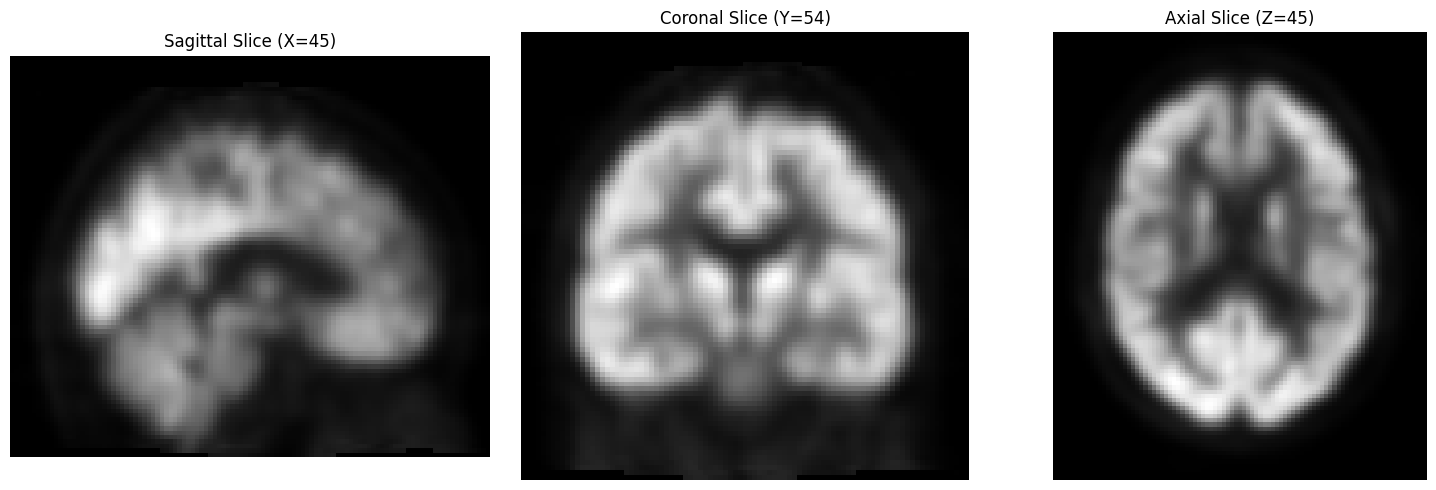

In [22]:
# Verify data with a test sample
i = 0
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    min_val = data[i].min().item()
    max_val = data[i].max().item()
    print(f"Min: {min_val}, Max: {max_val}")
    break

In [27]:
# Setting configurations

resnet_config = {
    'block': 'basic',
    'layers': [3, 4, 6, 3],
    'block_inplanes': [64, 128, 256, 512],
    'spatial_dims': 3,
    'n_input_channels': 1,
    'conv1_t_stride': 2,
    'num_classes': 1, 
    'shortcut_type': 'B',
    'bias_downsample': True
}

vit_config = {
    'in_channels': 256,
    'img_size': (6,7,6),
    'patch_size': (1,1,1),  
    'num_heads': 3,
    'hidden_size': 192,
    'mlp_dim': 768,
    'num_layers': 2,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.1,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}

pure_vit_config = {
    'in_channels': 1,
    'img_size': (91,109,91),
    'patch_size': (16,16,16),
    'num_heads': 5,
    'hidden_size': 330,
    'mlp_dim': 1200,
    'num_layers': 6,
    'proj_type': 'perceptron',
    'pos_embed_type': 'sincos',
    'classification': True,
    'num_classes': 1,
    'dropout_rate': 0.0,
    'spatial_dims': 3,
    'post_activation': 'none',
    'qkv_bias': False,
    'save_attn': False
}


# Nested Cross-Validation

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 150
EARLY_STOP_PATIENCE = 20

#learning_rates = [2e-7, 4e-7]
learning_rates = [2e-7] # CASO DECIDA USAR LR EM FUNCAO DE HEADS, DESCOMENTAR E EDITAR EM BAIXO
weight_decays = [2e-4]

layers_list = [6]
heads_list = [6]

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

print(f"\nArquitectures to be tested:\nlayers_list={layers_list}\n\t heads_list={heads_list}\n")
# For-loop over determined number of vit layers and heads
for dropout in [0.2, 0.3, 0.4]:
    vit_config['dropout_rate'] = dropout
    print(f"Testing dropout rate: {dropout}")
    for layers in layers_list:
        vit_config['num_layers'] = layers
        for heads in heads_list:
            vit_config['num_heads'] = heads
            if heads == 1:
                vit_config['hidden_size'] = 66
                vit_config['mlp_dim'] = 264
            elif heads == 2:
                vit_config['hidden_size'] = 126
                vit_config['mlp_dim'] = 504
            elif heads == 3:
                vit_config['hidden_size'] = 192
                vit_config['mlp_dim'] = 768
            elif heads == 4:
                vit_config['hidden_size'] = 252
                vit_config['mlp_dim'] = 1008
            elif heads == 5:
                vit_config['hidden_size'] = 330
                vit_config['mlp_dim'] = 1320
            elif heads == 6:
                vit_config['hidden_size'] = 384
                vit_config['mlp_dim'] = 1536
            elif heads == 7:
                vit_config['hidden_size'] = 462
                vit_config['mlp_dim'] = 1848
            elif heads == 8:
                vit_config['hidden_size'] = 504
                vit_config['mlp_dim'] = 2016
                
            dir3 = f"num_layers_{vit_config['num_layers']}/" 
            dir4 = f"num_heads_{vit_config['num_heads']}/"
            # Base directory for layers and heads
            RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + str(BATCH_SIZE) + "B/" + dir3 + dir4
            os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
            
            #if heads < 4:
                #learning_rates = [2e-7]
            #else:
                #learning_rates = [1e-7, 2e-7]
            
            # For-loop over determined learning rates and weight decays
            for current_lr in learning_rates:
                for current_wd in weight_decays:
                    print("=" * 60)
                    print(f"Testing Combination: ViT Layers={layers}, ViT Heads={heads}, LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
                    print(f"Hidden Size: {vit_config['hidden_size']}, MLP Dim: {vit_config['mlp_dim']}, Dropout: {dropout}")

                    combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e} (dropout={dropout})"
                        
                    combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
                    if os.path.exists(combo_results_dir):
                        print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
                        continue
                    
                    os.makedirs(combo_results_dir, exist_ok=True)
                    print(f"    Saving results for this combo to: {combo_results_dir}")
                    print("=" * 60)

                    start_time_combination = time.time()
                    
                    current_combo_val_losses = []
                    current_combo_val_accuracies = []
                    current_combo_val_aucs = []
                    current_combo_best_epoch = []
                    
                    current_combo_val_sensitivities = []
                    current_combo_val_specificities = []
                    current_combo_val_baccs = []
                    current_combo_val_f1s = []
                    current_combo_val_mccs = []

                    current_combo_test_losses = []
                    current_combo_test_accuracies = []
                    current_combo_test_aucs = []
                    
                    current_combo_test_sensitivities = []
                    current_combo_test_specificities = []
                    current_combo_test_baccs = []
                    current_combo_test_f1s = []
                    current_combo_test_mccs = []

                    fold_no = 1

                    # K-Fold Cross-Validation
                    for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
                        print("-" * 60)
                        print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
                        start_time_fold = time.time()

                        # Get paths and labels for the current fold
                        fold_train_paths = train_paths[train_indices]
                        fold_train_labels = train_labels[train_indices]
                        fold_val_paths = train_paths[val_indices]
                        fold_val_labels = train_labels[val_indices]

                        # Verify subject separation
                        train_subjects = set(subject_ids[train_indices])
                        val_subjects = set(subject_ids[val_indices])
                        if not train_subjects.isdisjoint(val_subjects):
                                raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

                        print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

                        # Calculate minmax parameters for the current training fold
                        fold_min, fold_max = calculate_min_max(fold_train_paths)

                        # Create fold train dataset
                        fold_train_data = create_dataloader(
                            paths=fold_train_paths,
                            labels=fold_train_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=True, 
                            seed=seed,
                            min_val=fold_min, 
                            max_val=fold_max,
                            mask_path=INPUT_ROI_MASK_PATH
                        ) 
                        
                        # Create fold validation dataset
                        fold_val_data = create_dataloader(
                            paths=fold_val_paths,
                            labels=fold_val_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=False, 
                            seed=None,
                            min_val=fold_min, 
                            max_val=fold_max,
                            mask_path=INPUT_ROI_MASK_PATH
                        )
                        
                        test_data = create_dataloader(
                            paths=test_paths,
                            labels=test_labels,
                            batch_size=BATCH_SIZE,
                            volume_shape=VOLUME_SHAPE,
                            is_training=False,
                            seed=None,
                            min_val=fold_min, 
                            max_val=fold_max,
                            mask_path=INPUT_ROI_MASK_PATH
                            )

                        if fold_train_data is None or fold_val_data is None or test_data is None:
                                raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                            
                        # Compute class weights for the current fold
                        unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
                        print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
                        pos_weight_val = class_counts[0] / class_counts[1]
                        pos_weight_val = torch.tensor([pos_weight_val], device=device)
                        print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

                        # Create the model
                        resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device)
                        model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

                        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
                        
                        optimizer = torch.optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
                    
                        best_val_loss = float('inf')
                        best_val_bacc = -float('inf')
                        epochs_no_improve = 0
                        best_epoch = 0
                        best_model_state = None
                        stopped_epoch = NUM_EPOCHS 

                        # Initialize history for this fold
                        history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                                'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': []}

                        for epoch in tqdm(range(NUM_EPOCHS)):
                            epoch_start_time = time.time()
                            history['epoch'].append(epoch + 1)

                            # ---------------- Train phase ----------------
                            model.train()
                            
                            running_loss = 0.0
                            train_pred_probs = []
                            train_targets = []
                            
                            for i, (inputs, labels) in enumerate(fold_train_data):
                                inputs = inputs.to(device)
                                labels = labels.float().unsqueeze(1).to(device)
                                
                                optimizer.zero_grad()
                                
                                # Mixed precision
                                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                    outputs = model(inputs)
                                    loss = criterion(outputs, labels)

                                scaler.scale(loss).backward()
                                scaler.step(optimizer)
                                scaler.update()

                                running_loss += loss.item() * inputs.size(0)
                                
                                prob_outputs = torch.sigmoid(outputs)
                                train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                                train_targets.extend(labels.detach().cpu().numpy())

                            train_targets = np.array(train_targets).flatten()
                            train_pred_probs = np.array(train_pred_probs).flatten()
                            
                            # Calculate training metrics for the epoch
                            train_loss = running_loss / len(fold_train_data.dataset)
                            train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                            train_auc = roc_auc_score(train_targets, train_pred_probs)
                            history['train_loss'].append(train_loss)
                            history['train_accuracy'].append(train_acc)
                            history['train_auc'].append(train_auc)

                            # ---------------- Validation phase ----------------
                            model.eval()
                            val_running_loss = 0.0
                            val_pred_probs = []
                            val_targets = []

                            with torch.inference_mode():
                                for inputs, labels in fold_val_data:
                                    inputs = inputs.to(device)
                                    labels = labels.float().unsqueeze(1).to(device)

                                    # Mixed precision
                                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                        outputs = model(inputs)
                                        loss = criterion(outputs, labels)

                                    val_running_loss += loss.item() * inputs.size(0)

                                    prob_outputs = torch.sigmoid(outputs)
                                    val_pred_probs.extend(prob_outputs.cpu().numpy())
                                    val_targets.extend(labels.cpu().numpy())
                                    
                            val_targets = np.array(val_targets).flatten()
                            val_pred_probs = np.array(val_pred_probs).flatten()

                            # Calculate validation metrics for the epoch
                            val_loss = val_running_loss / len(fold_val_data.dataset)
                            val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                            val_auc = roc_auc_score(val_targets, val_pred_probs)
                            
                            val_true = val_targets.astype(int)
                            val_pred = val_pred_probs.round().astype(int)
                            
                            val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                            val_specificity = recall_score(val_true, val_pred, pos_label=0)
                            val_bacc = balanced_accuracy_score(val_true, val_pred)
                            val_f1 = f1_score(val_true, val_pred, average='weighted')
                            val_mcc = matthews_corrcoef(val_true, val_pred)
                            
                            
                            history['val_loss'].append(val_loss)
                            history['val_accuracy'].append(val_acc)
                            history['val_auc'].append(val_auc)
                            
                            history['val_sensitivity'].append(val_sensitivity)
                            history['val_specificity'].append(val_specificity)
                            history['val_bacc'].append(val_bacc)
                            history['val_f1'].append(val_f1)
                            history['val_mcc'].append(val_mcc)

                            # Print Epoch Summary
                            epoch_duration = time.time() - epoch_start_time
                            #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                            #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                            #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                            

                            # Early stopping check
                            if DATASET == "smci_pmci_balanced":
                                # For smci_pmci_balanced, we monitor validation loss for early stopping (balanced dataset)
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    epochs_no_improve = 0
                                    # Save the model state with the lowest validation loss
                                    best_model_state = model.state_dict()
                                    best_epoch = epoch + 1
                                else:
                                    epochs_no_improve += 1
                            elif DATASET == "smci_pmci":
                                # For smci_pmci, we save the best balanced accuracy to deal with class imbalance and monitor the val loss for early stoppin                   
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    epochs_no_improve = 0    
                                else:
                                    epochs_no_improve += 1
                                    
                                if val_bacc > best_val_bacc:
                                    best_val_bacc = val_bacc
                                    # Save the best model state
                                    best_model_state = model.state_dict()
                                    best_epoch = epoch + 1
                            else:
                                raise ValueError("Invalid dataset. Add option to the if statement.")
                            
                            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                                model.load_state_dict(best_model_state)
                                print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                                break
                        
                        # Restore the best model state if early stopping was not triggered
                        if epochs_no_improve < EARLY_STOP_PATIENCE:
                            print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                            model.load_state_dict(best_model_state)
                            break
                        
                        # Save fold history and plots
                        fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
                        os.makedirs(fold_dir, exist_ok=True)
                        history_df = pd.DataFrame(history)
                        history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
                        history_df.to_csv(history_csv_path, index=False)
                        plot_loss_curves(history, fold_dir)

                        # Evaluate the fold
                        best_epoch_index = best_epoch - 1
                        
                        val_loss_best = history['val_loss'][best_epoch_index]
                        val_accuracy_best = history['val_accuracy'][best_epoch_index]
                        val_auc_best = history['val_auc'][best_epoch_index]
                        
                        val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
                        val_specificity_best = history['val_specificity'][best_epoch_index]
                        val_bacc_best = history['val_bacc'][best_epoch_index]
                        val_f1_best = history['val_f1'][best_epoch_index]
                        val_mcc_best = history['val_mcc'][best_epoch_index]
                        
                        print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                            f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

                        # Append results for this fold
                        current_combo_val_losses.append(val_loss_best)
                        current_combo_val_accuracies.append(val_accuracy_best)
                        current_combo_val_aucs.append(val_auc_best)
                        current_combo_best_epoch.append(best_epoch)
                        
                        current_combo_val_sensitivities.append(val_sensitivity_best)
                        current_combo_val_specificities.append(val_specificity_best)
                        current_combo_val_baccs.append(val_bacc_best)
                        current_combo_val_f1s.append(val_f1_best)
                        current_combo_val_mccs.append(val_mcc_best)
                        
                        optimizer_name = optimizer.__class__.__name__
                        
                        end_time_fold = time.time()
                        print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
                        fold_no += 1
                        
                        # Save the validation metrics for current fold
                        val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
                        with open(val_metrics_file_path, "w") as f:
                            f.write("--- Validation Metrics ---\n")
                            f.write(f"Loss:        {val_loss_best:.4f}\n")
                            f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                            f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                            f.write(f"Specificity: {val_specificity_best:.4f}\n")
                            f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                            f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                            f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                            f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
                        
                        # ---------------- Evaluate the model on the test data ---------------- 
                        model.eval()
                        test_running_loss = 0.0
                        test_pred_probs = []
                        test_targets = []

                        with torch.inference_mode():
                            for inputs, labels in test_data:
                                inputs = inputs.to(device)
                                labels = labels.float().unsqueeze(1).to(device)

                                # Mixed precision
                                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                                    outputs = model(inputs)
                                    loss = criterion(outputs, labels)

                                test_running_loss += loss.item() * inputs.size(0)
                            
                                prob_outputs = torch.sigmoid(outputs)
                                
                                test_pred_probs.extend(prob_outputs.cpu().numpy())
                                test_targets.extend(labels.cpu().numpy())

                        test_targets = np.array(test_targets).flatten()
                        test_pred_probs = np.array(test_pred_probs).flatten()

                        # Calculate test loss and accuracy
                        test_loss = test_running_loss / len(test_data.dataset)
                        test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

                        y_true = test_targets.astype(int)
                        y_pred = test_pred_probs.round().astype(int)

                        # Calculate metrics
                        test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
                        test_specificity = recall_score(y_true, y_pred, pos_label=0)
                        test_bacc = balanced_accuracy_score(y_true, y_pred)
                        test_f1 = f1_score(y_true, y_pred, average='weighted')
                        test_mcc = matthews_corrcoef(y_true, y_pred)
                        test_auc_score = roc_auc_score(y_true, y_pred)
                        
                        print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                            f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
                        
                        classes = DATASET.split("_")
                        class0, class1 = classes[0], classes[1]
                        target_names = [class0, class1]

                        # Save the confusion matrix plot
                        make_confusion_matrix(y_true=y_true,
                                            y_pred=y_pred.round(),
                                            classes=target_names,
                                            figsize=(8, 8),
                                            text_size=15,
                                            save_dir=fold_dir)

                        # Save the test loss and accuracy and the evaluation metrics
                        result_file_path = os.path.join(fold_dir, "test_results.txt")
                        with open(result_file_path, "w") as f:
                            f.write(f"[{test_loss}, {test_acc}]\n\n")
                            f.write("--- Evaluation Metrics on Test Set ---\n")
                            f.write(f"Accuracy:    {test_acc:.4f}\n")
                            f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                            f.write(f"Specificity: {test_specificity:.4f}\n")
                            f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                            f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                            f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                            f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                            
                        test_config = {
                            "vit_config": vit_config,
                            "num_epochs": int(best_epoch),
                            "optimizer": optimizer_name,
                            "optimizer_params": {
                                "lr": float(current_lr),
                                "weight_decay": float(current_wd)
                            },
                            "batch_size": BATCH_SIZE,
                            "seed": seed,
                            "dataset": DATASET
                        }
                        params_file_path = os.path.join(fold_dir, "test_config.json")
                        with open(params_file_path, "w") as f:
                            json.dump(test_config, f, indent=4)
                                
                        # Append results for this fold
                        current_combo_test_losses.append(test_loss)
                        current_combo_test_accuracies.append(test_acc)
                        current_combo_test_aucs.append(test_auc_score)
                        
                        current_combo_test_sensitivities.append(test_sensitivity)
                        current_combo_test_specificities.append(test_specificity)
                        current_combo_test_baccs.append(test_bacc)
                        current_combo_test_f1s.append(test_f1)
                        current_combo_test_mccs.append(test_mcc)
                        
                        # Free resources
                        del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
                        if device.type == 'cuda':
                            torch.cuda.empty_cache() 
                        gc.collect() 

                    end_time_combination = time.time()
                    print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

                    # Aggregate results across folds
                    avg_loss = np.mean(current_combo_val_losses)
                    std_loss = np.std(current_combo_val_losses)
                    avg_acc = np.mean(current_combo_val_accuracies)
                    std_acc = np.std(current_combo_val_accuracies)
                    avg_auc = np.mean(current_combo_val_aucs)
                    std_auc = np.std(current_combo_val_aucs)
                    
                    avg_sensitivity = np.mean(current_combo_val_sensitivities)
                    avg_specificity = np.mean(current_combo_val_specificities)
                    avg_bacc = np.mean(current_combo_val_baccs)
                    std_bacc = np.std(current_combo_val_baccs)
                    avg_f1 = np.mean(current_combo_val_f1s)
                    std_f1 = np.std(current_combo_val_f1s)
                    avg_mcc = np.mean(current_combo_val_mccs)

                    combo_average_results = {
                        'avg_val_loss': avg_loss,
                        'std_val_loss': std_loss,
                        'avg_val_accuracy': avg_acc,
                        'std_val_accuracy': std_acc,
                        'avg_val_auc': avg_auc,
                        'std_val_auc': std_auc,
                        'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
                        'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
                        'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
                        'best_epoch_per_fold': list(current_combo_best_epoch),
                        'avg_val_sensitivity': avg_sensitivity,
                        'avg_val_specificity': avg_specificity,
                        'avg_val_bacc': avg_bacc,
                        'std_val_bacc': std_bacc,
                        'avg_val_f1': avg_f1,
                        'std_val_f1': std_f1,
                        'avg_val_mcc': avg_mcc,
                        'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
                        'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
                        'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
                        'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
                        'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs],
                    }

                    # Save results in a txt file and the parameters in a json file
                    val_results_df = pd.DataFrame(combo_average_results)
                    display_cols = list(combo_average_results.keys())

                    val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
                    with open(val_results_filepath, "w") as f:
                        print("Validation Results Summary:", file=f)
                        print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

                        print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

                    avg_test_loss = np.mean(current_combo_test_losses)
                    std_test_loss = np.std(current_combo_test_losses)
                    avg_test_acc = np.mean(current_combo_test_accuracies)
                    std_test_acc = np.std(current_combo_test_accuracies)
                    avg_test_auc = np.mean(current_combo_test_aucs)
                    std_test_auc = np.std(current_combo_test_aucs)
                    
                    avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
                    std_test_sensitivity = np.std(current_combo_test_sensitivities)
                    avg_test_specificity = np.mean(current_combo_test_specificities)
                    std_test_specificity = np.std(current_combo_test_specificities)
                    avg_test_bacc = np.mean(current_combo_test_baccs)
                    std_test_bacc = np.std(current_combo_test_baccs)
                    avg_test_f1 = np.mean(current_combo_test_f1s)
                    std_test_f1 = np.std(current_combo_test_f1s)
                    avg_test_mcc = np.mean(current_combo_test_mccs)
                    std_test_mcc = np.std(current_combo_test_mccs)

                    combo_test_average_results = {
                        'avg_test_loss': avg_test_loss,	
                        'std_test_loss': std_test_loss,
                        'avg_test_accuracy': avg_test_acc,
                        'std_test_accuracy': std_test_acc,
                        'avg_test_auc': avg_test_auc,
                        'std_test_auc': std_test_auc,
                        'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
                        'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
                        'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
                        'avg_test_sensitivity': avg_test_sensitivity,
                        'std_test_sensitivity': std_test_sensitivity,
                        'avg_test_specificity': avg_test_specificity,
                        'std_test_specificity': std_test_specificity,
                        'avg_test_bacc': avg_test_bacc,
                        'std_test_bacc': std_test_bacc,
                        'avg_test_f1': avg_test_f1,
                        'std_test_f1': std_test_f1,
                        'avg_test_mcc': avg_test_mcc,
                        'std_test_mcc': std_test_mcc,
                        'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
                        'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
                        'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
                        'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
                        'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
                    }
                        
                    test_results_df = pd.DataFrame(combo_test_average_results)
                    display_cols = list(combo_test_average_results.keys())
                    test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
                    with open(test_results_filepath, "w") as f:
                        print("Test Results Summary:", file=f)
                        print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

                        print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

                    training_config = {
                        "vit_config": vit_config,
                        "num_folds": N_SPLITS,
                        "num_epochs": NUM_EPOCHS,
                        "early_stop_patience": EARLY_STOP_PATIENCE,
                        "optimizer": optimizer_name,
                        "optimizer_params": {
                            "lr": float(current_lr),
                            "weight_decay": float(current_wd)
                        },
                        "batch_size": BATCH_SIZE,
                        "seed": seed,
                        "dataset": DATASET
                    }
                    params_file_path = os.path.join(combo_results_dir, "training_config.json")
                    with open(params_file_path, "w") as f:
                        json.dump(training_config, f, indent=4)


Arquitectures to be tested:
layers_list=[6]
	 heads_list=[6]

Testing dropout rate: 0.2
Testing Combination: ViT Layers=6, ViT Heads=6, LR=2.0e-07, WeightDecay=2e-04
Hidden Size: 384, MLP Dim: 1536, Dropout: 0.2
    Saving results for this combo to: /home/diogommiranda/tese/outputs/resnetvit/smci_pmci/4B/num_layers_6/num_heads_6/LR_2.0e-07_WD_2e-04 (dropout=0.2)
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583


 41%|████      | 61/150 [11:24<16:38, 11.22s/it]


Early stopping triggered. Restoring best model weights from epoch 42.

    Fold 1 - Best Epoch 42, Val Loss: 0.6763, Acc: 0.7791, AUC: 0.8427, 
    Sensitivity: 0.7333, Specificity: 0.8058, BACC: 0.7696, F1: 0.7805, MCC: 0.5325
    Fold 1 finished in 685.80 seconds.


    Test Loss: 1.0694, Test Accuracy: 0.7647, AUC: 0.7424, 
    Sensitivity: 0.6667, Specificity: 0.8182, BACC: 0.7424, F1: 0.7647, MCC: 0.4848
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-07 and WD=2e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254


  3%|▎         | 5/150 [01:04<31:01, 12.84s/it]


KeyboardInterrupt: 

# Train a model with the best hyperparameters

Loading pretrained weights from path /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (70)/model.pth


Training the model from scratch with the best hyperparameters.
  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


  1%|▏         | 1/80 [00:03<04:38,  3.53s/it]

    Epoch 1/80 [3.53s] - Train Loss: 0.93087, Train Acc: 0.52418


  2%|▎         | 2/80 [00:06<04:28,  3.45s/it]

    Epoch 2/80 [3.38s] - Train Loss: 0.93107, Train Acc: 0.52306


  4%|▍         | 3/80 [00:10<04:20,  3.39s/it]

    Epoch 3/80 [3.32s] - Train Loss: 0.92645, Train Acc: 0.48256


  5%|▌         | 4/80 [00:13<04:14,  3.35s/it]

    Epoch 4/80 [3.29s] - Train Loss: 0.89713, Train Acc: 0.52756


  6%|▋         | 5/80 [00:16<04:12,  3.36s/it]

    Epoch 5/80 [3.38s] - Train Loss: 0.92898, Train Acc: 0.51069


  8%|▊         | 6/80 [00:20<04:08,  3.36s/it]

    Epoch 6/80 [3.34s] - Train Loss: 0.90260, Train Acc: 0.54218


  9%|▉         | 7/80 [00:24<04:21,  3.59s/it]

    Epoch 7/80 [4.07s] - Train Loss: 0.91794, Train Acc: 0.47357


 10%|█         | 8/80 [00:27<04:12,  3.51s/it]

    Epoch 8/80 [3.35s] - Train Loss: 0.90198, Train Acc: 0.52868


 11%|█▏        | 9/80 [00:31<04:06,  3.47s/it]

    Epoch 9/80 [3.36s] - Train Loss: 0.90359, Train Acc: 0.50394


 12%|█▎        | 10/80 [00:34<04:00,  3.44s/it]

    Epoch 10/80 [3.38s] - Train Loss: 0.90534, Train Acc: 0.52306


 14%|█▍        | 11/80 [00:37<03:55,  3.41s/it]

    Epoch 11/80 [3.35s] - Train Loss: 0.90404, Train Acc: 0.48819


 15%|█▌        | 12/80 [00:41<03:49,  3.38s/it]

    Epoch 12/80 [3.29s] - Train Loss: 0.91664, Train Acc: 0.55906


 16%|█▋        | 13/80 [00:44<03:45,  3.36s/it]

    Epoch 13/80 [3.32s] - Train Loss: 0.90206, Train Acc: 0.46907


 18%|█▊        | 14/80 [00:47<03:41,  3.36s/it]

    Epoch 14/80 [3.35s] - Train Loss: 0.89782, Train Acc: 0.49606


 19%|█▉        | 15/80 [00:51<03:37,  3.35s/it]

    Epoch 15/80 [3.33s] - Train Loss: 0.89857, Train Acc: 0.56805


 20%|██        | 16/80 [00:55<03:51,  3.61s/it]

    Epoch 16/80 [4.23s] - Train Loss: 0.89043, Train Acc: 0.52306


 21%|██▏       | 17/80 [00:58<03:47,  3.62s/it]

    Epoch 17/80 [3.61s] - Train Loss: 0.89019, Train Acc: 0.53768


 22%|██▎       | 18/80 [01:02<03:39,  3.55s/it]

    Epoch 18/80 [3.38s] - Train Loss: 0.89321, Train Acc: 0.54556


 24%|██▍       | 19/80 [01:05<03:32,  3.48s/it]

    Epoch 19/80 [3.33s] - Train Loss: 0.89138, Train Acc: 0.53768


 25%|██▌       | 20/80 [01:08<03:24,  3.41s/it]

    Epoch 20/80 [3.24s] - Train Loss: 0.89515, Train Acc: 0.53768


 26%|██▋       | 21/80 [01:12<03:20,  3.40s/it]

    Epoch 21/80 [3.39s] - Train Loss: 0.88885, Train Acc: 0.52193


 28%|██▊       | 22/80 [01:15<03:16,  3.38s/it]

    Epoch 22/80 [3.34s] - Train Loss: 0.85908, Train Acc: 0.61080


 29%|██▉       | 23/80 [01:18<03:12,  3.38s/it]

    Epoch 23/80 [3.37s] - Train Loss: 0.88579, Train Acc: 0.54893


 30%|███       | 24/80 [01:22<03:11,  3.41s/it]

    Epoch 24/80 [3.49s] - Train Loss: 0.84745, Train Acc: 0.59280


 31%|███▏      | 25/80 [01:25<03:07,  3.40s/it]

    Epoch 25/80 [3.37s] - Train Loss: 0.86604, Train Acc: 0.58155


 32%|███▎      | 26/80 [01:30<03:16,  3.65s/it]

    Epoch 26/80 [4.22s] - Train Loss: 0.79449, Train Acc: 0.67154


 34%|███▍      | 27/80 [01:33<03:09,  3.58s/it]

    Epoch 27/80 [3.41s] - Train Loss: 0.75778, Train Acc: 0.66479


 35%|███▌      | 28/80 [01:36<03:02,  3.51s/it]

    Epoch 28/80 [3.37s] - Train Loss: 0.66129, Train Acc: 0.75928


 36%|███▋      | 29/80 [01:40<02:57,  3.49s/it]

    Epoch 29/80 [3.42s] - Train Loss: 0.68912, Train Acc: 0.73341


 38%|███▊      | 30/80 [01:43<02:52,  3.45s/it]

    Epoch 30/80 [3.36s] - Train Loss: 0.57792, Train Acc: 0.78628


 39%|███▉      | 31/80 [01:46<02:46,  3.41s/it]

    Epoch 31/80 [3.31s] - Train Loss: 0.47599, Train Acc: 0.83915


 40%|████      | 32/80 [01:50<02:40,  3.34s/it]

    Epoch 32/80 [3.20s] - Train Loss: 0.62929, Train Acc: 0.78740


 41%|████▏     | 33/80 [01:53<02:36,  3.32s/it]

    Epoch 33/80 [3.27s] - Train Loss: 0.52547, Train Acc: 0.80877


 42%|████▎     | 34/80 [01:56<02:31,  3.30s/it]

    Epoch 34/80 [3.26s] - Train Loss: 0.47688, Train Acc: 0.84364


 44%|████▍     | 35/80 [02:00<02:38,  3.52s/it]

    Epoch 35/80 [4.04s] - Train Loss: 0.44989, Train Acc: 0.84139


 45%|████▌     | 36/80 [02:04<02:34,  3.50s/it]

    Epoch 36/80 [3.45s] - Train Loss: 0.44196, Train Acc: 0.85039


 46%|████▋     | 37/80 [02:07<02:29,  3.48s/it]

    Epoch 37/80 [3.44s] - Train Loss: 0.42099, Train Acc: 0.85602


 48%|████▊     | 38/80 [02:10<02:23,  3.41s/it]

    Epoch 38/80 [3.25s] - Train Loss: 0.37295, Train Acc: 0.87402


 49%|████▉     | 39/80 [02:14<02:17,  3.34s/it]

    Epoch 39/80 [3.18s] - Train Loss: 0.36226, Train Acc: 0.87852


 50%|█████     | 40/80 [02:17<02:13,  3.35s/it]

    Epoch 40/80 [3.36s] - Train Loss: 0.37274, Train Acc: 0.87514


 51%|█████▏    | 41/80 [02:20<02:10,  3.36s/it]

    Epoch 41/80 [3.37s] - Train Loss: 0.43463, Train Acc: 0.83690


 52%|█████▎    | 42/80 [02:24<02:07,  3.36s/it]

    Epoch 42/80 [3.37s] - Train Loss: 0.35146, Train Acc: 0.88076


 54%|█████▍    | 43/80 [02:27<02:04,  3.35s/it]

    Epoch 43/80 [3.34s] - Train Loss: 0.33908, Train Acc: 0.88639


 55%|█████▌    | 44/80 [02:30<02:00,  3.34s/it]

    Epoch 44/80 [3.31s] - Train Loss: 0.31451, Train Acc: 0.89876


 56%|█████▋    | 45/80 [02:34<02:06,  3.60s/it]

    Epoch 45/80 [4.22s] - Train Loss: 0.31797, Train Acc: 0.90326


 57%|█████▊    | 46/80 [02:38<02:00,  3.55s/it]

    Epoch 46/80 [3.43s] - Train Loss: 0.31595, Train Acc: 0.89876


 59%|█████▉    | 47/80 [02:41<01:56,  3.53s/it]

    Epoch 47/80 [3.46s] - Train Loss: 0.30618, Train Acc: 0.90101


 60%|██████    | 48/80 [02:45<01:51,  3.48s/it]

    Epoch 48/80 [3.37s] - Train Loss: 0.30455, Train Acc: 0.90776


 61%|██████▏   | 49/80 [02:48<01:46,  3.44s/it]

    Epoch 49/80 [3.36s] - Train Loss: 0.31802, Train Acc: 0.90326


 62%|██████▎   | 50/80 [02:51<01:42,  3.40s/it]

    Epoch 50/80 [3.31s] - Train Loss: 0.23699, Train Acc: 0.93026


 64%|██████▍   | 51/80 [02:55<01:37,  3.37s/it]

    Epoch 51/80 [3.30s] - Train Loss: 0.29073, Train Acc: 0.89876


 65%|██████▌   | 52/80 [02:58<01:34,  3.37s/it]

    Epoch 52/80 [3.38s] - Train Loss: 0.22723, Train Acc: 0.92238


 66%|██████▋   | 53/80 [03:01<01:31,  3.38s/it]

    Epoch 53/80 [3.39s] - Train Loss: 0.26240, Train Acc: 0.92351


 68%|██████▊   | 54/80 [03:05<01:28,  3.40s/it]

    Epoch 54/80 [3.45s] - Train Loss: 0.28651, Train Acc: 0.91789


 69%|██████▉   | 55/80 [03:09<01:31,  3.65s/it]

    Epoch 55/80 [4.21s] - Train Loss: 0.24683, Train Acc: 0.92801


 70%|███████   | 56/80 [03:13<01:26,  3.60s/it]

    Epoch 56/80 [3.50s] - Train Loss: 0.25664, Train Acc: 0.92126


 71%|███████▏  | 57/80 [03:16<01:20,  3.51s/it]

    Epoch 57/80 [3.28s] - Train Loss: 0.21737, Train Acc: 0.93363


 72%|███████▎  | 58/80 [03:19<01:15,  3.43s/it]

    Epoch 58/80 [3.26s] - Train Loss: 0.24031, Train Acc: 0.93363


 74%|███████▍  | 59/80 [03:23<01:11,  3.42s/it]

    Epoch 59/80 [3.41s] - Train Loss: 0.20639, Train Acc: 0.94038


 75%|███████▌  | 60/80 [03:26<01:08,  3.40s/it]

    Epoch 60/80 [3.35s] - Train Loss: 0.22318, Train Acc: 0.93363


 76%|███████▋  | 61/80 [03:29<01:04,  3.39s/it]

    Epoch 61/80 [3.36s] - Train Loss: 0.19565, Train Acc: 0.93813


 78%|███████▊  | 62/80 [03:33<01:01,  3.40s/it]

    Epoch 62/80 [3.42s] - Train Loss: 0.20883, Train Acc: 0.94488


 79%|███████▉  | 63/80 [03:36<00:58,  3.45s/it]

    Epoch 63/80 [3.58s] - Train Loss: 0.20404, Train Acc: 0.93251


 80%|████████  | 64/80 [03:41<01:01,  3.83s/it]

    Epoch 64/80 [4.72s] - Train Loss: 0.19531, Train Acc: 0.93701


 81%|████████▏ | 65/80 [03:44<00:55,  3.72s/it]

    Epoch 65/80 [3.46s] - Train Loss: 0.22677, Train Acc: 0.93251


 82%|████████▎ | 66/80 [03:48<00:50,  3.62s/it]

    Epoch 66/80 [3.39s] - Train Loss: 0.16441, Train Acc: 0.94938


 84%|████████▍ | 67/80 [03:51<00:45,  3.53s/it]

    Epoch 67/80 [3.32s] - Train Loss: 0.19039, Train Acc: 0.94488


 85%|████████▌ | 68/80 [03:54<00:41,  3.44s/it]

    Epoch 68/80 [3.23s] - Train Loss: 0.16053, Train Acc: 0.95388


 86%|████████▋ | 69/80 [03:58<00:37,  3.38s/it]

    Epoch 69/80 [3.24s] - Train Loss: 0.21037, Train Acc: 0.93363


 88%|████████▊ | 70/80 [04:01<00:33,  3.34s/it]

    Epoch 70/80 [3.25s] - Train Loss: 0.14850, Train Acc: 0.95951


 89%|████████▉ | 71/80 [04:04<00:30,  3.36s/it]

    Epoch 71/80 [3.40s] - Train Loss: 0.16413, Train Acc: 0.95276


 90%|█████████ | 72/80 [04:08<00:26,  3.37s/it]

    Epoch 72/80 [3.38s] - Train Loss: 0.18616, Train Acc: 0.94038


 91%|█████████▏| 73/80 [04:11<00:23,  3.41s/it]

    Epoch 73/80 [3.50s] - Train Loss: 0.13737, Train Acc: 0.96625


 92%|█████████▎| 74/80 [04:15<00:21,  3.66s/it]

    Epoch 74/80 [4.24s] - Train Loss: 0.17814, Train Acc: 0.95276


 94%|█████████▍| 75/80 [04:19<00:17,  3.56s/it]

    Epoch 75/80 [3.32s] - Train Loss: 0.13059, Train Acc: 0.95838


 95%|█████████▌| 76/80 [04:22<00:13,  3.49s/it]

    Epoch 76/80 [3.32s] - Train Loss: 0.12919, Train Acc: 0.96400


 96%|█████████▋| 77/80 [04:26<00:10,  3.46s/it]

    Epoch 77/80 [3.40s] - Train Loss: 0.13757, Train Acc: 0.95838


 98%|█████████▊| 78/80 [04:29<00:06,  3.43s/it]

    Epoch 78/80 [3.37s] - Train Loss: 0.18266, Train Acc: 0.94376


 99%|█████████▉| 79/80 [04:32<00:03,  3.42s/it]

    Epoch 79/80 [3.40s] - Train Loss: 0.15956, Train Acc: 0.96288


100%|██████████| 80/80 [04:36<00:00,  3.45s/it]

    Epoch 80/80 [3.50s] - Train Loss: 0.15701, Train Acc: 0.96288
Model saved to: /home/diogommiranda/tese/outputs/best_model.pth


Test Loss: 1.2123030774733599, Test Acc: 0.7104072398190046

--- Evaluation Metrics on Test Set ---
Accuracy:    0.7104
Sensitivity: 0.6923
Specificity: 0.7203 
Balanced Accuracy (BACC): 0.7063
F1 Score (Weighted):      0.7153
Matthews Corr Coef (MCC): 0.3988
Area Under the Curve (AUC): 0.7063



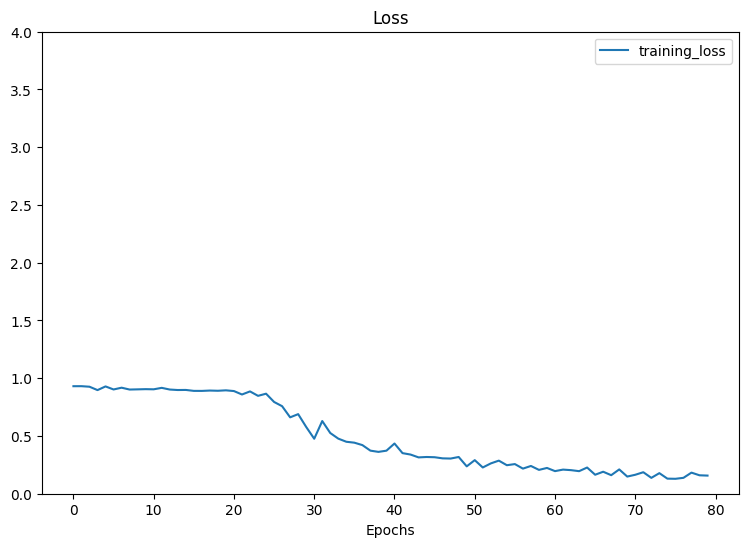

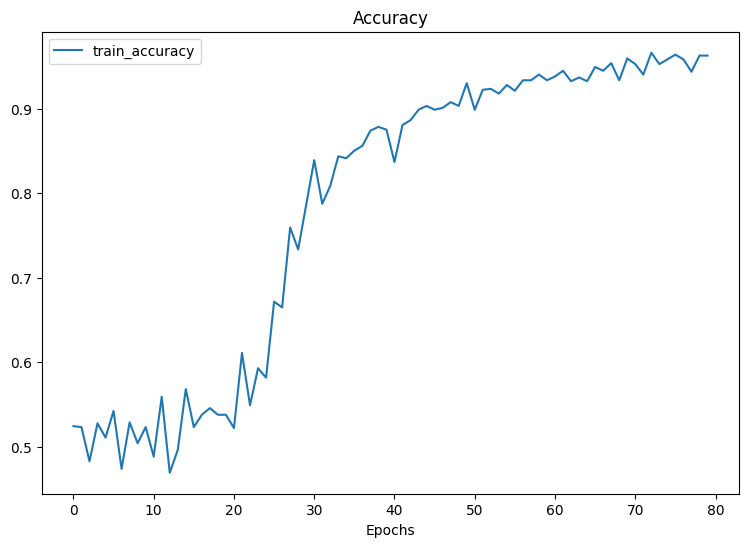

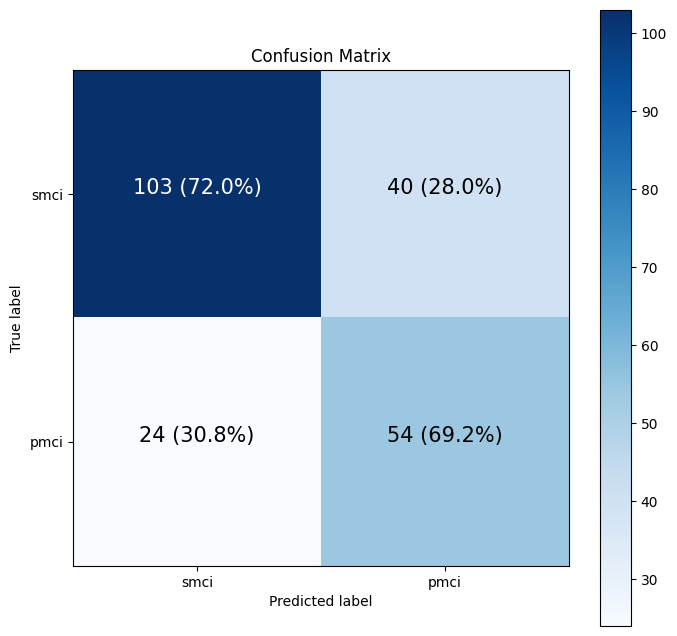

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 2e-5 # Learning rate
BEST_WD= 4e-2 # Weight decay
BEST_NUM_EPOCHS = 80 # Number of epochs for training

train_for_more_epochs = False 
loading = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Create the model
resnet_feature_extractor = ResnetFeatureExtractor(resnet_config=resnet_config, device=device)
model = ResNetViT(resnet_feature_extractor, vit_config).to(device)

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    print(f"\nTraining the model from scratch with the best hyperparameters.")

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=current_lr, weight_decay=current_wd)


optimizer_name = optimizer.__class__.__name__

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    
    # Freeze BatchNorm layers if using pretrained model
    
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    

# Save the model if using fixed learning rate in case we want to continue training it
if not loading:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    save_model_dir = "/home/diogommiranda/tese/outputs/resnetvit/" + DATASET + "/" + str(BATCH_SIZE) + "B/" + "saved_models/" + f"LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
        training_config = {
            "vit_config": vit_config,
            "num_epochs": BEST_NUM_EPOCHS,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(BEST_LR),
                "weight_decay": float(BEST_WD)
            },
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(save_model_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/resnetvit/nc_ad/pretrain/fixed_lr/4B/saved_models/LR=3.0e-06_WD=2e-04
